In [81]:
import pandas as pd
import networkx as nx
import plotly.express as px
import plotly.colors as pc  # Import for generating colors
import matplotlib.pyplot as plt
from testing import *
from src.models.qsar_OLS_pca import *

In [82]:
# Load the data
df = pd.read_csv("src/data/IC50_df.csv")

___________________________
Making piecarts to visualize the initial distributions in the dataset 

- Grouping by the CDKs ("Target Name": 47 unique)
- Grouping by the Ligands ("BindingDB Ligand Name", 4577 unique)

In [ ]:
# Group by 'Target Name' and count occurrences
cdk_count = df["Target Name"].value_counts()

# Set a threshold for grouping smaller categories into "Other"
threshold = 0.01 * cdk_count.sum()  # Adjust threshold maybe 0.05

# Separate main categories and calculate "Other"
cdk_main = cdk_count[cdk_count > threshold]
other_count = cdk_count[cdk_count <= threshold].sum()

# Append "Other" as a separate row
cdk_main = pd.concat([cdk_main, pd.Series({"Other": other_count})])

# Sort by counts in decreasing order
cdk_main = cdk_main.sort_values(ascending=False)

# Create a DataFrame for Plotly
cdk_data = pd.DataFrame({
    "Target Name": cdk_main.index,
    "Count": cdk_main.values
})

# Generate a color for each category using Plotly's color sequence
color_sequence = pc.qualitative.Set3  # Select a color palette
colors = {name: color_sequence[i % len(color_sequence)] for i, name in enumerate(cdk_data["Target Name"])}

# Create an interactive sunburst chart using Plotly
fig = px.sunburst(
    cdk_data,
    path=["Target Name"],  # Defines the hierarchical structure
    values="Count",
    title="CDK Distribution in the Dataset",
    color="Target Name",  # Use Target Name for consistent color mapping
    color_discrete_map=colors,  # Assign the color mapping
)

# Customize hover template to show name and percentage, and remove text labels
fig.update_traces(
    hovertemplate="<b>%{label}</b><br>%{value} binding samples<br>%{percentParent:.1%} of total dataset",
    textinfo="none"  # Removes text labels from the plot
)

# Adjust legend position to fit within the visualization
fig.update_layout(
    margin=dict(t=50, l=50, r=300, b=50),  # Adjust right margin for better spacing
    annotations=[
        {
            "text": "<b>Legend:</b><br>" + "<br>".join(
                f"<span style='color:{colors[label]}'>⬤</span> {label}: {value}"
                for label, value in zip(cdk_data["Target Name"], cdk_data["Count"])
            ),
            "align": "left",
            "showarrow": False,
            "x": 1.3,  # Position legend farther to the right
            "y": 0.5,
            "xref": "paper",
            "yref": "paper",
            "font": {"size": 10},  # Reduce font size for better fit
        }
    ]
)

# Show the figure
fig.show()


A pie chart for the ligands distribution will not work since there are so many where only one sample is taken...

In [88]:
df["BindingDB Ligand Name"].value_counts()

BindingDB Ligand Name
(2R)-2-[[6-(benzylamino)-9-isopropyl-purin-2-yl]amino]butan-1-ol::(2R)-2-[[6-(benzylamino)-9-propan-2-ylpurin-2-yl]amino]butan-1-ol::(2R)-2-[[6-[(phenylmethyl)amino]-9-propan-2-yl-2-purinyl]amino]-1-butanol::(2R)-2-[[6-[(phenylmethyl)amino]-9-propan-2-yl-purin-2-yl]amino]butan-1-ol::(2R)-2-{[6-(benzylamino)-9-(propan-2-yl)-9H-purin-2-yl]amino}butan-1-ol::(R)-Roscovitine::2,6,9-Trisubstituted purine deriv. 28::CHEMBL14762::CYC-202::Roscovitine::cid_160355    17
1-Acyl-1H-[1,2,4]triazole-3,5-diamine Analogue 3b::4-({5-amino-1-[(2,6-difluorophenyl)carbonyl]-1H-1,2,4-triazol-3-yl}amino)benzene-1-sulfonamide::4-[[5-Amino-1-(2,6-difluorobenzoyl)-1H-1,2,4-triazol-3-yl]amino]-benzenesulfonamide::CHEMBL191003::JNJ-7706621::cid_5330790                                                                                                                                                                                                14
BMS-387072::CHEMBL296468::N-(5-{[(5-tert-butyl-1

_________________

A network graph showing initial connections between unique CDKs and ligands

In [100]:
# Extract relevant columns for the graph (Ligand SMILES and Target Name)
df_edges = df[['Ligand SMILES', 'Target Name']].dropna().drop_duplicates()

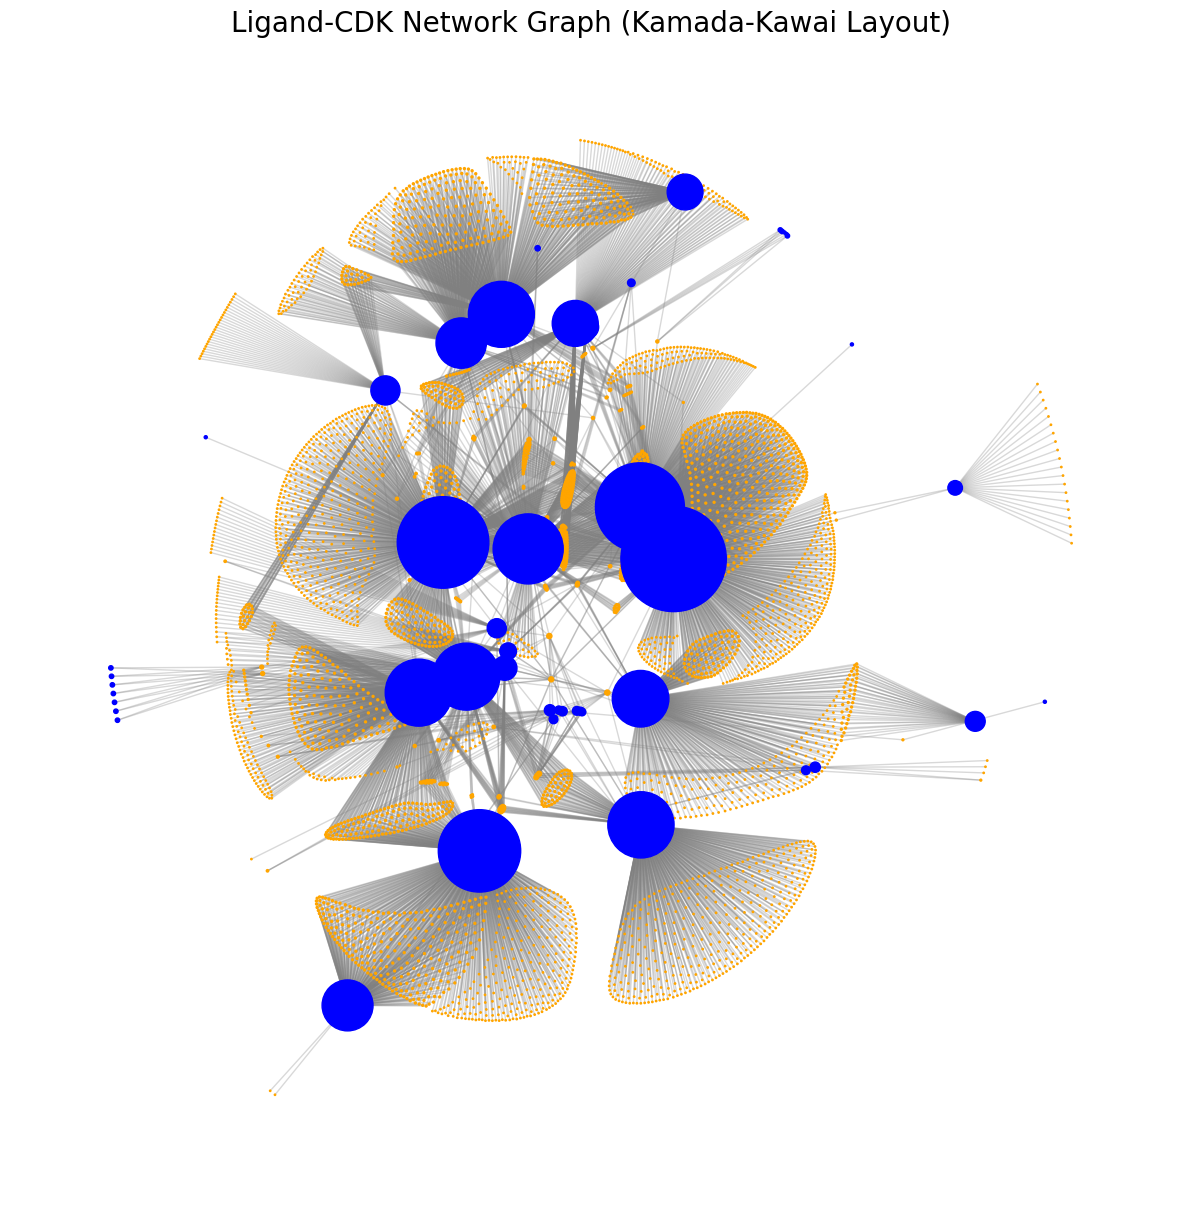

In [101]:
# Create a graph
G = nx.Graph()

# Add nodes and edges
ligands = df_edges['Ligand SMILES'].unique()
cdks = df_edges['Target Name'].unique()

G.add_nodes_from(ligands, type='ligand')  # Ligand nodes
G.add_nodes_from(cdks, type='cdk')       # CDK nodes
G.add_edges_from(zip(df_edges['Ligand SMILES'], df_edges['Target Name']))  # Connections

# Define node colors
node_colors = [
    'blue' if G.nodes[node]['type'] == 'cdk' else 'orange'
    for node in G.nodes
]

# Calculate node degrees (number of connections for each node)
node_degrees = dict(G.degree())

# Define node sizes dynamically based on degree
node_sizes = [
    node_degrees[node] * 5 if G.nodes[node]['type'] == 'cdk' else node_degrees[node] * 1
    for node in G.nodes
]

# Plot the graph
plt.figure(figsize=(15, 15))

# Use Kamada-Kawai layout for better spacing
pos = nx.kamada_kawai_layout(G)

# Draw edges and nodes
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='gray')
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)

# Final touches
plt.title("Ligand-CDK Network Graph (Kamada-Kawai Layout)", fontsize=20)
plt.axis('off')
plt.show()

